In [6]:
# import geopandas as gpd
# import os
# import xarray as xr
# import numpy as np
# import pandas as pd
# import copy
# import pickle 
# import matplotlib.pyplot as plt
# from tsai.all import *

In [1]:
import xarray as xr
import numpy as np
import copy
from glob import glob
from shapely.geometry import box
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

/opt/conda/envs/eurac_env/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_535219/530352280.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_p

In [2]:
data_dir = '/mnt/CEPH_PROJECTS/sao/openEO_Platform'

In [3]:
big_pv_geoms = gpd.read_file(f"{data_dir}/germany_photovoltaic.shp")

In [4]:
# Filter the data to have farms bigger then 5 km2
big_pv_geoms_32632 = big_pv_geoms.to_crs(32632)
big_pv_geoms_32632_buffer_20 = copy.deepcopy(big_pv_geoms_32632)
big_pv_geoms_32632_buffer_20["geometry"] = [i.buffer(20) for i in big_pv_geoms_32632_buffer_20.geometry]
big_pv_geoms_buffer = big_pv_geoms_32632_buffer_20.to_crs(4326)


print(f"Number of selected PV Farms: {len(big_pv_geoms_buffer)}")

Number of selected PV Farms: 4458


In [5]:
bands = ['B01','B02','B03','B04',
         'B05','B06','B07','B08',
         'B8A', 'B11', 'B12']

### Extract the data

In [6]:
# Plot random PV farm
farm_id = 2

data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{farm_id}.nc",decode_coords="all")
geom = big_pv_geoms_32632.iloc[farm_id]  

# This step to fill the gaps (nan values) spatially
data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
data.rio.write_crs("epsg:32633", inplace=True) #32633

# Filter clouds pixels
cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32633")
data = data.where(~cloud_mask)

# Clip the farm polygon
clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

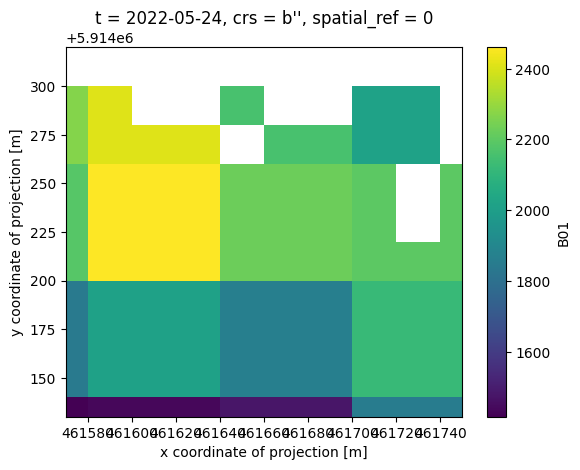

In [7]:
data['B01'][55].plot()

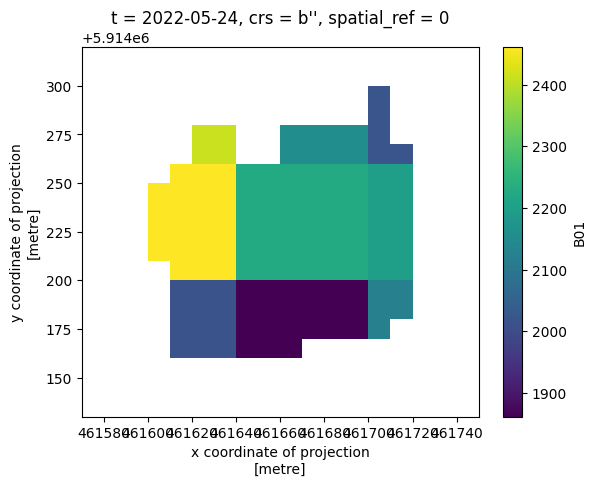

In [8]:
clipped['B01'][55].plot()

In [9]:
def temp_s2_data(stat_name, pv_farms, start_date='2022-01-01', end_date='2022-12-31', train=True, invert=False):
    
    all_pixels_ts = []
    for pv_farm in pv_farms:
        farm_id = int(pv_farm.split('/')[-1].split('_')[-1].split('.')[0])
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{farm_id}.nc",decode_coords="all")
        geom = big_pv_geoms_32632.iloc[farm_id]


         # Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32633")
        data = data.where(~cloud_mask)  

        # This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633   

        # Filter the dataset based on time [Feb, Nov]
        filtered_ds = data.sel(t=slice(start_date, end_date))
            
        # Monthly stats 
        ds_monthly = filtered_ds.resample({"t": "M"}).apply(statistics_functions[stat_name])      
        
            
        # Linear interpolate for missing values 
        ds_monthly_interp = ds_monthly.interpolate_na(dim='t', method='linear')           
            
        # Crop the farm 
        clipped = ds_monthly_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=invert)    
        
        if train:
            df = clipped.to_dataframe().unstack(level='t')
        else:
            df = ds_monthly_interp.to_dataframe().unstack(level='t')
            
            
        arr_ts= []
        for b in bands:
            df_b = df[b]
            if train:
                df_b = df_b.dropna(how = 'all')
            if invert:
                # Randomly select 25% of the pixels 
                rows_to_filter = int(0.25 * len(df_b))
                df_b = df_b.sample(n=rows_to_filter, random_state=42)
                
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))
        
    
    samples = np.vstack(all_pixels_ts)
    
    return samples

In [10]:
# Define a list of statistics functions
statistics_functions = {
    "mean": lambda x: x.mean(dim="t",skipna=True),
    "median": lambda x: x.median(dim="t",skipna=True),
    "std": lambda x: x.std(dim="t",skipna=True),
    "quantile_10": lambda x: x.quantile(0.1, dim="t"),  
    "quantile_90": lambda x: x.quantile(0.90, dim="t"),
}


# Define the list of statistics names
statistics_names = list(statistics_functions.keys())

In [ ]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"
pv_farms = glob(f"{data_dir}/s2/germany/*.nc")

# Initialize a dictionary to store the results
results = {}

# Loop through each statistic
for stat_name in statistics_names:
    ds_monthly = temp_s2_data(stat_name, pv_farms[500:]) 
    # Store the result in the dictionary
    results[stat_name] = ds_monthly  

/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

In [ ]:
pv_samples= np.concatenate(list(results.values()), axis=-1)
np.save(f'{data_dir}/s2/germany/extracted_temporal_data/pv_samples.npy', pv_samples)

In [ ]:
# Initialize a dictionary to store the results
results = {}

# Loop through each statistic
for stat_name in statistics_names:
    # Resample the dataset to monthly means using the current statistic function
    ds_monthly = temp_s2_data(stat_name, pv_farms[500:], invert=True) #filtered_ds.resample({"t": "M"}).apply(statistics_functions[stat_name])
    # Store the result in the dictionary
    results[stat_name] = ds_monthly    

/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

In [ ]:
non_pv_samples= np.concatenate(list(results.values()), axis=-1)
np.save(f'{data_dir}/s2/germany/extracted_temporal_data/non_pv_samples.npy', non_pv_samples)

In [ ]:
########################## I am here #################################

In [38]:
def temporal_metric(stat_name,  invert=False):
    start_date = '2022-02-01'
    end_date = '2022-11-30'
    
    all_pixels_ts = []
    #Keep 10% out to use them for testing 
    for i, geom in big_pv_geoms_32632[280:].iterrows():

        try:
           #print('I am here 0.1')
            
            data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
            #print('I am here 0')
            ## Filter clouds pixels
            cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
            geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
            data = data.where(~cloud_mask)  

            ## This step to fill the gaps (nan values) spatially
            data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
            data.rio.write_crs("epsg:32633", inplace=True) #32633

            # Filter the dataset based on time [Feb, Nov]
            filtered_ds = data.sel(t=slice(start_date, end_date))

            # Weekly mean 
            #ds_monthly = filtered_ds.resample({"t": "M"}).mean(skipna=True)
            ds_monthly = filtered_ds.resample({"t": "M"}).apply(statistics_functions[stat_name])
           # print('I am here 1')

            # Linear interpolate for missing values 
            ds_monthly_interp = ds_monthly.interpolate_na(dim='t', method='linear')
           # print('I am here 2')

            # Crop the farm 
            clipped = ds_monthly_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=invert)
            # print(clipped.t.values.shape)
            # print('------------------------------')
           # print('I am here 3')

            #Extract the monthly mean 
            df = clipped.to_dataframe().unstack(level='t')
            #print('I am here 4')
            arr_ts= []
            for b in bands:
               # print('I am here 5')
                df_b = df[b]
                df_b = df_b.dropna(how = 'all')
                arr_ts.append(np.array(df_b))



            all_pixels_ts.append(np.stack(arr_ts, axis=1))   

        except:
            print(f"This polygon id: {i} is not exist.")
            
    samples = np.vstack(all_pixels_ts)
    return samples

In [27]:
# Define a list of statistics functions
statistics_functions = {
    "mean": lambda x: x.mean(dim="t",skipna=True),
    "median": lambda x: x.median(dim="t",skipna=True),
    "std": lambda x: x.std(dim="t",skipna=True),
    "quantile_25": lambda x: x.quantile(0.25, dim="t"),
    "quantile_10": lambda x: x.quantile(0.1, dim="t"),  
    "quantile_75": lambda x: x.quantile(0.75, dim="t"),
    "quantile_90": lambda x: x.quantile(0.75, dim="t"),
}

# Define the list of statistics names
statistics_names = list(statistics_functions.keys())

In [74]:

# Initialize a dictionary to store the results
results = {}

# Loop through each statistic
for stat_name in statistics_names:
    # Resample the dataset to monthly means using the current statistic function
    ds_monthly = temporal_metric(stat_name) #filtered_ds.resample({"t": "M"}).apply(statistics_functions[stat_name])
    # Store the result in the dictionary
    results[stat_name] = ds_monthly    


This polygon id: 280 is not exist.
This polygon id: 282 is not exist.
This polygon id: 284 is not exist.
This polygon id: 287 is not exist.
This polygon id: 288 is not exist.
This polygon id: 294 is not exist.
This polygon id: 307 is not exist.
This polygon id: 308 is not exist.
This polygon id: 315 is not exist.
This polygon id: 328 is not exist.
This polygon id: 342 is not exist.
This polygon id: 344 is not exist.
This polygon id: 348 is not exist.
This polygon id: 350 is not exist.
This polygon id: 351 is not exist.
This polygon id: 353 is not exist.
This polygon id: 356 is not exist.
This polygon id: 365 is not exist.
This polygon id: 375 is not exist.
This polygon id: 376 is not exist.
This polygon id: 377 is not exist.
This polygon id: 386 is not exist.
This polygon id: 390 is not exist.
This polygon id: 400 is not exist.
This polygon id: 403 is not exist.
This polygon id: 414 is not exist.
This polygon id: 422 is not exist.
This polygon id: 424 is not exist.
This polygon id: 425

/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 307 is not exist.
This polygon id: 308 is not exist.
This polygon id: 315 is not exist.
This polygon id: 328 is not exist.
This polygon id: 342 is not exist.
This polygon id: 344 is not exist.
This polygon id: 348 is not exist.
This polygon id: 350 is not exist.
This polygon id: 351 is not exist.
This polygon id: 353 is not exist.
This polygon id: 356 is not exist.
This polygon id: 365 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 375 is not exist.
This polygon id: 376 is not exist.
This polygon id: 377 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 386 is not exist.
This polygon id: 390 is not exist.
This polygon id: 400 is not exist.
This polygon id: 403 is not exist.
This polygon id: 414 is not exist.
This polygon id: 422 is not exist.
This polygon id: 424 is not exist.
This polygon id: 425 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 439 is not exist.
This polygon id: 441 is not exist.
This polygon id: 472 is not exist.
This polygon id: 486 is not exist.
This polygon id: 492 is not exist.
This polygon id: 498 is not exist.
This polygon id: 500 is not exist.
This polygon id: 501 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 509 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 521 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 539 is not exist.
This polygon id: 540 is not exist.
This polygon id: 570 is not exist.
This polygon id: 577 is not exist.
This polygon id: 579 is not exist.
This polygon id: 583 is not exist.
This polygon id: 590 is not exist.
This polygon id: 591 is not exist.
This polygon id: 596 is not exist.
This polygon id: 610 is not exist.
This polygon id: 611 is not exist.
This polygon id: 615 is not exist.
This polygon id: 617 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 625 is not exist.
This polygon id: 627 is not exist.
This polygon id: 639 is not exist.
This polygon id: 641 is not exist.
This polygon id: 649 is not exist.
This polygon id: 655 is not exist.
This polygon id: 657 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 676 is not exist.
This polygon id: 686 is not exist.
This polygon id: 711 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 723 is not exist.
This polygon id: 737 is not exist.
This polygon id: 738 is not exist.
This polygon id: 739 is not exist.
This polygon id: 740 is not exist.
This polygon id: 741 is not exist.
This polygon id: 742 is not exist.
This polygon id: 743 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 745 is not exist.
This polygon id: 746 is not exist.
This polygon id: 747 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 751 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 757 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 760 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 766 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 779 is not exist.
This polygon id: 782 is not exist.
This polygon id: 787 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 800 is not exist.
This polygon id: 801 is not exist.
This polygon id: 808 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 816 is not exist.
This polygon id: 822 is not exist.
This polygon id: 824 is not exist.
This polygon id: 826 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 838 is not exist.
This polygon id: 841 is not exist.
This polygon id: 842 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 861 is not exist.
This polygon id: 867 is not exist.
This polygon id: 885 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 889 is not exist.
This polygon id: 902 is not exist.
This polygon id: 920 is not exist.
This polygon id: 937 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 962 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 998 is not exist.
This polygon id: 1001 is not exist.
This polygon id: 1010 is not exist.
This polygon id: 1035 is not exist.
This polygon id: 1051 is not exist.
This polygon id: 1052 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1078 is not exist.
This polygon id: 1087 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1100 is not exist.
This polygon id: 1101 is not exist.
This polygon id: 1103 is not exist.
This polygon id: 1118 is not exist.
This polygon id: 1122 is not exist.
This polygon id: 1126 is not exist.
This polygon id: 1134 is not exist.
This polygon id: 1135 is not exist.
This polygon id: 1136 is not exist.
This polygon id: 1141 is not exist.
This polygon id: 1152 is not exist.
This polygon id: 1154 is not exist.
This polygon id: 1169 is not exist.
This polygon id: 1170 is not exist.
This polygon id: 1178 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1186 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1204 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1223 is not exist.
This polygon id: 1231 is not exist.
This polygon id: 1244 is not exist.
This polygon id: 1246 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1264 is not exist.
This polygon id: 1283 is not exist.
This polygon id: 1286 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1312 is not exist.
This polygon id: 1313 is not exist.
This polygon id: 1314 is not exist.
This polygon id: 1323 is not exist.
This polygon id: 1333 is not exist.
This polygon id: 1340 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1345 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1363 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1379 is not exist.
This polygon id: 1384 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1390 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1400 is not exist.
This polygon id: 1407 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1424 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


This polygon id: 1426 is not exist.
This polygon id: 1427 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1434 is not exist.
This polygon id: 1435 is not exist.
This polygon id: 1438 is not exist.
This polygon id: 1441 is not exist.
This polygon id: 1442 is not exist.
This polygon id: 1443 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1451 is not exist.
This polygon id: 1455 is not exist.
This polygon id: 1456 is not exist.
This polygon id: 1462 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1483 is not exist.
This polygon id: 1496 is not exist.
This polygon id: 1499 is not exist.
This polygon id: 1501 is not exist.
This polygon id: 1502 is not exist.
This polygon id: 1504 is not exist.
This polygon id: 1505 is not exist.
This polygon id: 1508 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1539 is not exist.
This polygon id: 1542 is not exist.
This polygon id: 1543 is not exist.
This polygon id: 1544 is not exist.
This polygon id: 1545 is not exist.
This polygon id: 1546 is not exist.
This polygon id: 1547 is not exist.
This polygon id: 1548 is not exist.
This polygon id: 1549 is not exist.
This polygon id: 1566 is not exist.
This polygon id: 1598 is not exist.
This polygon id: 1599 is not exist.
This polygon id: 1612 is not exist.
This polygon id: 1613 is not exist.
This polygon id: 1614 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1621 is not exist.
This polygon id: 1639 is not exist.
This polygon id: 1643 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1651 is not exist.
This polygon id: 1652 is not exist.
This polygon id: 1653 is not exist.
This polygon id: 1664 is not exist.
This polygon id: 1681 is not exist.
This polygon id: 1684 is not exist.
This polygon id: 1689 is not exist.
This polygon id: 1695 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1702 is not exist.
This polygon id: 1706 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1721 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1750 is not exist.
This polygon id: 1779 is not exist.
This polygon id: 1786 is not exist.
This polygon id: 1792 is not exist.
This polygon id: 1795 is not exist.
This polygon id: 1797 is not exist.
This polygon id: 1810 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1815 is not exist.
This polygon id: 1819 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1827 is not exist.
This polygon id: 1835 is not exist.
This polygon id: 1846 is not exist.
This polygon id: 1853 is not exist.
This polygon id: 1854 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1864 is not exist.
This polygon id: 1868 is not exist.
This polygon id: 1874 is not exist.
This polygon id: 1876 is not exist.
This polygon id: 1877 is not exist.
This polygon id: 1878 is not exist.
This polygon id: 1880 is not exist.
This polygon id: 1891 is not exist.
This polygon id: 1894 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1902 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1906 is not exist.
This polygon id: 1910 is not exist.
This polygon id: 1918 is not exist.
This polygon id: 1919 is not exist.
This polygon id: 1920 is not exist.
This polygon id: 1921 is not exist.
This polygon id: 1922 is not exist.
This polygon id: 1923 is not exist.
This polygon id: 1930 is not exist.
This polygon id: 1931 is not exist.
This polygon id: 1934 is not exist.
This polygon id: 1935 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1961 is not exist.
This polygon id: 1962 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1970 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1985 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1994 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2001 is not exist.
This polygon id: 2002 is not exist.
This polygon id: 2005 is not exist.
This polygon id: 2006 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2010 is not exist.
This polygon id: 2012 is not exist.
This polygon id: 2013 is not exist.
This polygon id: 2017 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2033 is not exist.
This polygon id: 2040 is not exist.
This polygon id: 2041 is not exist.
This polygon id: 2042 is not exist.
This polygon id: 2049 is not exist.
This polygon id: 2054 is not exist.
This polygon id: 2055 is not exist.
This polygon id: 2056 is not exist.
This polygon id: 2057 is not exist.
This polygon id: 2058 is not exist.
This polygon id: 2059 is not exist.
This polygon id: 2061 is not exist.
This polygon id: 2062 is not exist.
This polygon id: 2063 is not exist.
This polygon id: 2066 is not exist.
This polygon id: 2067 is not exist.
This polygon id: 2068 is not exist.
This polygon id: 2069 is not exist.
This polygon id: 2074 is not exist.
This polygon id: 2075 is not exist.
This polygon id: 2076 is not exist.
This polygon id: 2077 is not exist.
This polygon id: 2078 is not exist.
This polygon id: 2079 is not exist.
This polygon id: 2080 is not exist.
This polygon id: 2081 is not exist.
This polygon id: 2083 is not exist.
This polygon id: 2084 is not

/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2120 is not exist.
This polygon id: 2123 is not exist.
This polygon id: 2128 is not exist.
This polygon id: 2134 is not exist.
This polygon id: 2139 is not exist.
This polygon id: 2151 is not exist.
This polygon id: 2154 is not exist.
This polygon id: 2155 is not exist.
This polygon id: 2156 is not exist.
This polygon id: 2158 is not exist.
This polygon id: 2167 is not exist.
This polygon id: 2168 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2188 is not exist.
This polygon id: 2192 is not exist.
This polygon id: 2193 is not exist.
This polygon id: 2194 is not exist.
This polygon id: 2195 is not exist.
This polygon id: 2196 is not exist.
This polygon id: 2198 is not exist.
This polygon id: 2199 is not exist.
This polygon id: 2200 is not exist.
This polygon id: 2207 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2230 is not exist.
This polygon id: 2240 is not exist.
This polygon id: 2242 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2250 is not exist.
This polygon id: 2251 is not exist.
This polygon id: 2252 is not exist.
This polygon id: 2258 is not exist.
This polygon id: 2263 is not exist.
This polygon id: 2265 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2278 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2288 is not exist.
This polygon id: 2290 is not exist.
This polygon id: 2292 is not exist.
This polygon id: 2308 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2313 is not exist.
This polygon id: 2320 is not exist.
This polygon id: 2321 is not exist.
This polygon id: 2330 is not exist.
This polygon id: 2331 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2341 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2346 is not exist.
This polygon id: 2348 is not exist.
This polygon id: 2354 is not exist.
This polygon id: 2355 is not exist.
This polygon id: 2356 is not exist.
This polygon id: 2358 is not exist.
This polygon id: 2362 is not exist.
This polygon id: 2363 is not exist.
This polygon id: 2364 is not exist.
This polygon id: 2365 is not exist.
This polygon id: 2367 is not exist.
This polygon id: 2368 is not exist.
This polygon id: 2376 is not exist.
This polygon id: 2377 is not exist.
This polygon id: 2380 is not exist.
This polygon id: 2402 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2413 is not exist.
This polygon id: 2416 is not exist.
This polygon id: 2417 is not exist.
This polygon id: 2418 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2424 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2449 is not exist.
This polygon id: 2454 is not exist.
This polygon id: 2471 is not exist.
This polygon id: 2472 is not exist.
This polygon id: 2473 is not exist.
This polygon id: 2474 is not exist.
This polygon id: 2485 is not exist.
This polygon id: 2486 is not exist.
This polygon id: 2494 is not exist.
This polygon id: 2495 is not exist.
This polygon id: 2508 is not exist.
This polygon id: 2509 is not exist.
This polygon id: 2512 is not exist.
This polygon id: 2515 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2527 is not exist.
This polygon id: 2528 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2539 is not exist.
This polygon id: 2546 is not exist.
This polygon id: 2549 is not exist.
This polygon id: 2550 is not exist.
This polygon id: 2560 is not exist.
This polygon id: 2563 is not exist.
This polygon id: 2564 is not exist.
This polygon id: 2581 is not exist.
This polygon id: 2584 is not exist.
This polygon id: 2586 is not exist.
This polygon id: 2592 is not exist.
This polygon id: 2593 is not exist.
This polygon id: 2598 is not exist.
This polygon id: 2609 is not exist.
This polygon id: 2629 is not exist.
This polygon id: 2634 is not exist.
This polygon id: 2636 is not exist.
This polygon id: 2637 is not exist.
This polygon id: 2643 is not exist.
This polygon id: 2644 is not exist.
This polygon id: 2648 is not exist.
This polygon id: 2657 is not exist.
This polygon id: 2663 is not exist.
This polygon id: 2664 is not exist.
This polygon id: 2666 is not exist.
This polygon id: 2673 is not exist.
This polygon id: 2681 is not exist.
This polygon id: 2684 is not

/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2688 is not exist.
This polygon id: 2691 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2694 is not exist.
This polygon id: 2695 is not exist.
This polygon id: 2701 is not exist.
This polygon id: 2702 is not exist.
This polygon id: 2703 is not exist.
This polygon id: 2720 is not exist.
This polygon id: 2721 is not exist.
This polygon id: 2727 is not exist.
This polygon id: 2741 is not exist.
This polygon id: 2742 is not exist.
This polygon id: 2746 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2751 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2755 is not exist.
This polygon id: 2756 is not exist.
This polygon id: 2757 is not exist.
This polygon id: 2758 is not exist.
This polygon id: 2760 is not exist.
This polygon id: 2761 is not exist.
This polygon id: 2762 is not exist.
This polygon id: 2773 is not exist.
This polygon id: 2815 is not exist.
This polygon id: 2818 is not exist.
This polygon id: 2819 is not exist.
This polygon id: 2820 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2828 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2847 is not exist.
This polygon id: 2850 is not exist.
This polygon id: 2851 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2857 is not exist.
This polygon id: 2860 is not exist.
This polygon id: 2862 is not exist.
This polygon id: 2863 is not exist.
This polygon id: 2867 is not exist.
This polygon id: 2869 is not exist.
This polygon id: 2873 is not exist.
This polygon id: 2876 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2879 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2890 is not exist.
This polygon id: 2896 is not exist.
This polygon id: 2897 is not exist.
This polygon id: 2898 is not exist.
This polygon id: 2902 is not exist.
This polygon id: 2913 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2925 is not exist.
This polygon id: 2926 is not exist.
This polygon id: 2927 is not exist.
This polygon id: 2928 is not exist.
This polygon id: 2929 is not exist.
This polygon id: 2939 is not exist.
This polygon id: 2940 is not exist.
This polygon id: 2941 is not exist.
This polygon id: 2947 is not exist.
This polygon id: 2951 is not exist.
This polygon id: 2954 is not exist.
This polygon id: 2955 is not exist.
This polygon id: 2956 is not exist.
This polygon id: 2957 is not exist.
This polygon id: 2963 is not exist.
This polygon id: 2975 is not exist.
This polygon id: 2979 is not exist.
This polygon id: 2980 is not exist.
This polygon id: 2999 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 3007 is not exist.
This polygon id: 3012 is not exist.
This polygon id: 3015 is not exist.
This polygon id: 3024 is not exist.
This polygon id: 3026 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 3033 is not exist.
This polygon id: 3037 is not exist.
This polygon id: 3040 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 3048 is not exist.
This polygon id: 3051 is not exist.
This polygon id: 3052 is not exist.
This polygon id: 3069 is not exist.
This polygon id: 3074 is not exist.
This polygon id: 3075 is not exist.
This polygon id: 3076 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 3083 is not exist.
This polygon id: 3088 is not exist.
This polygon id: 3092 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 3124 is not exist.
This polygon id: 3128 is not exist.
This polygon id: 3151 is not exist.
This polygon id: 3152 is not exist.
This polygon id: 3153 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 3156 is not exist.
This polygon id: 3157 is not exist.
This polygon id: 3158 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 3161 is not exist.
This polygon id: 3162 is not exist.
This polygon id: 3164 is not exist.
This polygon id: 3166 is not exist.
This polygon id: 3167 is not exist.
This polygon id: 3169 is not exist.
This polygon id: 3170 is not exist.
This polygon id: 3188 is not exist.
This polygon id: 3189 is not exist.
This polygon id: 3190 is not exist.
This polygon id: 3193 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 3203 is not exist.
This polygon id: 3204 is not exist.
This polygon id: 3205 is not exist.
This polygon id: 3210 is not exist.
This polygon id: 3211 is not exist.
This polygon id: 3212 is not exist.
This polygon id: 3213 is not exist.
This polygon id: 3215 is not exist.
This polygon id: 3218 is not exist.
This polygon id: 3219 is not exist.
This polygon id: 3220 is not exist.
This polygon id: 3221 is not exist.
This polygon id: 3222 is not exist.
This polygon id: 3223 is not exist.
This polygon id: 3224 is not exist.
This polygon id: 3225 is not exist.
This polygon id: 3226 is not exist.
This polygon id: 3227 is not exist.
This polygon id: 3228 is not exist.
This polygon id: 3229 is not exist.
This polygon id: 3230 is not exist.
This polygon id: 3231 is not exist.
This polygon id: 3232 is not exist.
This polygon id: 3233 is not exist.
This polygon id: 3234 is not exist.
This polygon id: 3235 is not exist.
This polygon id: 3236 is not exist.
This polygon id: 3237 is not

/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 4037 is not exist.
This polygon id: 4045 is not exist.
This polygon id: 4046 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 4051 is not exist.
This polygon id: 4052 is not exist.
This polygon id: 4057 is not exist.
This polygon id: 4058 is not exist.
This polygon id: 4059 is not exist.
This polygon id: 4060 is not exist.
This polygon id: 4084 is not exist.
This polygon id: 4085 is not exist.
This polygon id: 4086 is not exist.
This polygon id: 4091 is not exist.
This polygon id: 4092 is not exist.
This polygon id: 4093 is not exist.
This polygon id: 4103 is not exist.
This polygon id: 4104 is not exist.
This polygon id: 4107 is not exist.
This polygon id: 4109 is not exist.
This polygon id: 4110 is not exist.
This polygon id: 4117 is not exist.
This polygon id: 4118 is not exist.
This polygon id: 4119 is not exist.
This polygon id: 4120 is not exist.
This polygon id: 4121 is not exist.
This polygon id: 4122 is not exist.
This polygon id: 4123 is not exist.
This polygon id: 4124 is not exist.
This polygon id: 4125 is not exist.
This polygon id: 4126 is not exist.
This polygon id: 4127 is not

In [ ]:
pv_samples = np.concatenate(list(results.values()), axis=-1)
y1 = np.ones(pv_samples.shape[0])

print(pv_samples.shape)
print(y1.shape)

In [76]:
# Initialize a dictionary to store the results
results = {}

# Loop through each statistic
for stat_name in statistics_names:
    # Resample the dataset to monthly means using the current statistic function
    ds_monthly = temporal_metric(stat_name, invert=True) #filtered_ds.resample({"t": "M"}).apply(statistics_functions[stat_name])
    # Store the result in the dictionary
    results[stat_name] = ds_monthly 
    
    
non_pv_samples= np.concatenate(list(results.values()), axis=-1)
y0 = np.zeros(non_pv_samples.shape[0])

print(non_pv_samples.shape)
print(y0.shape)

This polygon id: 280 is not exist.
This polygon id: 282 is not exist.
This polygon id: 284 is not exist.
This polygon id: 287 is not exist.
This polygon id: 288 is not exist.
This polygon id: 294 is not exist.
This polygon id: 307 is not exist.
This polygon id: 308 is not exist.
This polygon id: 315 is not exist.
This polygon id: 328 is not exist.
This polygon id: 342 is not exist.
This polygon id: 344 is not exist.
This polygon id: 348 is not exist.
This polygon id: 350 is not exist.
This polygon id: 351 is not exist.
This polygon id: 353 is not exist.
This polygon id: 356 is not exist.
This polygon id: 365 is not exist.
This polygon id: 375 is not exist.
This polygon id: 376 is not exist.
This polygon id: 377 is not exist.
This polygon id: 386 is not exist.
This polygon id: 390 is not exist.
This polygon id: 400 is not exist.
This polygon id: 403 is not exist.
This polygon id: 414 is not exist.
This polygon id: 422 is not exist.
This polygon id: 424 is not exist.
This polygon id: 425

/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 307 is not exist.
This polygon id: 308 is not exist.
This polygon id: 315 is not exist.
This polygon id: 328 is not exist.
This polygon id: 342 is not exist.
This polygon id: 344 is not exist.
This polygon id: 348 is not exist.
This polygon id: 350 is not exist.
This polygon id: 351 is not exist.
This polygon id: 353 is not exist.
This polygon id: 356 is not exist.
This polygon id: 365 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 375 is not exist.
This polygon id: 376 is not exist.
This polygon id: 377 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 386 is not exist.
This polygon id: 390 is not exist.
This polygon id: 400 is not exist.
This polygon id: 403 is not exist.
This polygon id: 414 is not exist.
This polygon id: 422 is not exist.
This polygon id: 424 is not exist.
This polygon id: 425 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 439 is not exist.
This polygon id: 441 is not exist.
This polygon id: 472 is not exist.
This polygon id: 486 is not exist.
This polygon id: 492 is not exist.
This polygon id: 498 is not exist.
This polygon id: 500 is not exist.
This polygon id: 501 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 509 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 521 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 539 is not exist.
This polygon id: 540 is not exist.
This polygon id: 570 is not exist.
This polygon id: 577 is not exist.
This polygon id: 579 is not exist.
This polygon id: 583 is not exist.
This polygon id: 590 is not exist.
This polygon id: 591 is not exist.
This polygon id: 596 is not exist.
This polygon id: 610 is not exist.
This polygon id: 611 is not exist.
This polygon id: 615 is not exist.
This polygon id: 617 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 625 is not exist.
This polygon id: 627 is not exist.
This polygon id: 639 is not exist.
This polygon id: 641 is not exist.
This polygon id: 649 is not exist.
This polygon id: 655 is not exist.
This polygon id: 657 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 676 is not exist.
This polygon id: 686 is not exist.
This polygon id: 711 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 723 is not exist.
This polygon id: 737 is not exist.
This polygon id: 738 is not exist.
This polygon id: 739 is not exist.
This polygon id: 740 is not exist.
This polygon id: 741 is not exist.
This polygon id: 742 is not exist.
This polygon id: 743 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 745 is not exist.
This polygon id: 746 is not exist.
This polygon id: 747 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 751 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 757 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 760 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 766 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 779 is not exist.
This polygon id: 782 is not exist.
This polygon id: 787 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 800 is not exist.
This polygon id: 801 is not exist.
This polygon id: 808 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 816 is not exist.
This polygon id: 822 is not exist.
This polygon id: 824 is not exist.
This polygon id: 826 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 838 is not exist.
This polygon id: 841 is not exist.
This polygon id: 842 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 861 is not exist.
This polygon id: 867 is not exist.
This polygon id: 885 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 889 is not exist.
This polygon id: 902 is not exist.
This polygon id: 920 is not exist.
This polygon id: 937 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 962 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 998 is not exist.
This polygon id: 1001 is not exist.
This polygon id: 1010 is not exist.
This polygon id: 1035 is not exist.
This polygon id: 1051 is not exist.
This polygon id: 1052 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1078 is not exist.
This polygon id: 1087 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1100 is not exist.
This polygon id: 1101 is not exist.
This polygon id: 1103 is not exist.
This polygon id: 1118 is not exist.
This polygon id: 1122 is not exist.
This polygon id: 1126 is not exist.
This polygon id: 1134 is not exist.
This polygon id: 1135 is not exist.
This polygon id: 1136 is not exist.
This polygon id: 1141 is not exist.
This polygon id: 1152 is not exist.
This polygon id: 1154 is not exist.
This polygon id: 1169 is not exist.
This polygon id: 1170 is not exist.
This polygon id: 1178 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1186 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1204 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1223 is not exist.
This polygon id: 1231 is not exist.
This polygon id: 1244 is not exist.
This polygon id: 1246 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1264 is not exist.
This polygon id: 1283 is not exist.
This polygon id: 1286 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1312 is not exist.
This polygon id: 1313 is not exist.
This polygon id: 1314 is not exist.
This polygon id: 1323 is not exist.
This polygon id: 1333 is not exist.
This polygon id: 1340 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1345 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1363 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1379 is not exist.
This polygon id: 1384 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1390 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1400 is not exist.
This polygon id: 1407 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1424 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


This polygon id: 1426 is not exist.
This polygon id: 1427 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1434 is not exist.
This polygon id: 1435 is not exist.
This polygon id: 1438 is not exist.
This polygon id: 1441 is not exist.
This polygon id: 1442 is not exist.
This polygon id: 1443 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1451 is not exist.
This polygon id: 1455 is not exist.
This polygon id: 1456 is not exist.
This polygon id: 1462 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1483 is not exist.
This polygon id: 1496 is not exist.
This polygon id: 1499 is not exist.
This polygon id: 1501 is not exist.
This polygon id: 1502 is not exist.
This polygon id: 1504 is not exist.
This polygon id: 1505 is not exist.
This polygon id: 1508 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1539 is not exist.
This polygon id: 1542 is not exist.
This polygon id: 1543 is not exist.
This polygon id: 1544 is not exist.
This polygon id: 1545 is not exist.
This polygon id: 1546 is not exist.
This polygon id: 1547 is not exist.
This polygon id: 1548 is not exist.
This polygon id: 1549 is not exist.
This polygon id: 1566 is not exist.
This polygon id: 1598 is not exist.
This polygon id: 1599 is not exist.
This polygon id: 1612 is not exist.
This polygon id: 1613 is not exist.
This polygon id: 1614 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1621 is not exist.
This polygon id: 1639 is not exist.
This polygon id: 1643 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1651 is not exist.
This polygon id: 1652 is not exist.
This polygon id: 1653 is not exist.
This polygon id: 1664 is not exist.
This polygon id: 1681 is not exist.
This polygon id: 1684 is not exist.
This polygon id: 1689 is not exist.
This polygon id: 1695 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1702 is not exist.
This polygon id: 1706 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1721 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1750 is not exist.
This polygon id: 1779 is not exist.
This polygon id: 1786 is not exist.
This polygon id: 1792 is not exist.
This polygon id: 1795 is not exist.
This polygon id: 1797 is not exist.
This polygon id: 1810 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1815 is not exist.
This polygon id: 1819 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1827 is not exist.
This polygon id: 1835 is not exist.
This polygon id: 1846 is not exist.
This polygon id: 1853 is not exist.
This polygon id: 1854 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1864 is not exist.
This polygon id: 1868 is not exist.
This polygon id: 1874 is not exist.
This polygon id: 1876 is not exist.
This polygon id: 1877 is not exist.
This polygon id: 1878 is not exist.
This polygon id: 1880 is not exist.
This polygon id: 1891 is not exist.
This polygon id: 1894 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1902 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1906 is not exist.
This polygon id: 1910 is not exist.
This polygon id: 1918 is not exist.
This polygon id: 1919 is not exist.
This polygon id: 1920 is not exist.
This polygon id: 1921 is not exist.
This polygon id: 1922 is not exist.
This polygon id: 1923 is not exist.
This polygon id: 1930 is not exist.
This polygon id: 1931 is not exist.
This polygon id: 1934 is not exist.
This polygon id: 1935 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1961 is not exist.
This polygon id: 1962 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1970 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1985 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 1994 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2001 is not exist.
This polygon id: 2002 is not exist.
This polygon id: 2005 is not exist.
This polygon id: 2006 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2010 is not exist.
This polygon id: 2012 is not exist.
This polygon id: 2013 is not exist.
This polygon id: 2017 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2033 is not exist.
This polygon id: 2040 is not exist.
This polygon id: 2041 is not exist.
This polygon id: 2042 is not exist.
This polygon id: 2049 is not exist.
This polygon id: 2054 is not exist.
This polygon id: 2055 is not exist.
This polygon id: 2056 is not exist.
This polygon id: 2057 is not exist.
This polygon id: 2058 is not exist.
This polygon id: 2059 is not exist.
This polygon id: 2061 is not exist.
This polygon id: 2062 is not exist.
This polygon id: 2063 is not exist.
This polygon id: 2066 is not exist.
This polygon id: 2067 is not exist.
This polygon id: 2068 is not exist.
This polygon id: 2069 is not exist.
This polygon id: 2074 is not exist.
This polygon id: 2075 is not exist.
This polygon id: 2076 is not exist.
This polygon id: 2077 is not exist.
This polygon id: 2078 is not exist.
This polygon id: 2079 is not exist.
This polygon id: 2080 is not exist.
This polygon id: 2081 is not exist.
This polygon id: 2083 is not exist.
This polygon id: 2084 is not

/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2120 is not exist.
This polygon id: 2123 is not exist.
This polygon id: 2128 is not exist.
This polygon id: 2134 is not exist.
This polygon id: 2139 is not exist.
This polygon id: 2151 is not exist.
This polygon id: 2154 is not exist.
This polygon id: 2155 is not exist.
This polygon id: 2156 is not exist.
This polygon id: 2158 is not exist.
This polygon id: 2167 is not exist.
This polygon id: 2168 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2188 is not exist.
This polygon id: 2192 is not exist.
This polygon id: 2193 is not exist.
This polygon id: 2194 is not exist.
This polygon id: 2195 is not exist.
This polygon id: 2196 is not exist.
This polygon id: 2198 is not exist.
This polygon id: 2199 is not exist.
This polygon id: 2200 is not exist.
This polygon id: 2207 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2230 is not exist.
This polygon id: 2240 is not exist.
This polygon id: 2242 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2250 is not exist.
This polygon id: 2251 is not exist.
This polygon id: 2252 is not exist.
This polygon id: 2258 is not exist.
This polygon id: 2263 is not exist.
This polygon id: 2265 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2278 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2288 is not exist.
This polygon id: 2290 is not exist.
This polygon id: 2292 is not exist.
This polygon id: 2308 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2313 is not exist.
This polygon id: 2320 is not exist.
This polygon id: 2321 is not exist.
This polygon id: 2330 is not exist.
This polygon id: 2331 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2341 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2346 is not exist.
This polygon id: 2348 is not exist.
This polygon id: 2354 is not exist.
This polygon id: 2355 is not exist.
This polygon id: 2356 is not exist.
This polygon id: 2358 is not exist.
This polygon id: 2362 is not exist.
This polygon id: 2363 is not exist.
This polygon id: 2364 is not exist.
This polygon id: 2365 is not exist.
This polygon id: 2367 is not exist.
This polygon id: 2368 is not exist.
This polygon id: 2376 is not exist.
This polygon id: 2377 is not exist.
This polygon id: 2380 is not exist.
This polygon id: 2402 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2413 is not exist.
This polygon id: 2416 is not exist.
This polygon id: 2417 is not exist.
This polygon id: 2418 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2424 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2449 is not exist.
This polygon id: 2454 is not exist.
This polygon id: 2471 is not exist.
This polygon id: 2472 is not exist.
This polygon id: 2473 is not exist.
This polygon id: 2474 is not exist.
This polygon id: 2485 is not exist.
This polygon id: 2486 is not exist.
This polygon id: 2494 is not exist.
This polygon id: 2495 is not exist.
This polygon id: 2508 is not exist.
This polygon id: 2509 is not exist.
This polygon id: 2512 is not exist.
This polygon id: 2515 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2527 is not exist.
This polygon id: 2528 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2539 is not exist.
This polygon id: 2546 is not exist.
This polygon id: 2549 is not exist.
This polygon id: 2550 is not exist.
This polygon id: 2560 is not exist.
This polygon id: 2563 is not exist.
This polygon id: 2564 is not exist.
This polygon id: 2581 is not exist.
This polygon id: 2584 is not exist.
This polygon id: 2586 is not exist.
This polygon id: 2592 is not exist.
This polygon id: 2593 is not exist.
This polygon id: 2598 is not exist.
This polygon id: 2609 is not exist.
This polygon id: 2629 is not exist.
This polygon id: 2634 is not exist.
This polygon id: 2636 is not exist.
This polygon id: 2637 is not exist.
This polygon id: 2643 is not exist.
This polygon id: 2644 is not exist.
This polygon id: 2648 is not exist.
This polygon id: 2657 is not exist.
This polygon id: 2663 is not exist.
This polygon id: 2664 is not exist.
This polygon id: 2666 is not exist.
This polygon id: 2673 is not exist.
This polygon id: 2681 is not exist.
This polygon id: 2684 is not

/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2688 is not exist.
This polygon id: 2691 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2694 is not exist.
This polygon id: 2695 is not exist.
This polygon id: 2701 is not exist.
This polygon id: 2702 is not exist.
This polygon id: 2703 is not exist.
This polygon id: 2720 is not exist.
This polygon id: 2721 is not exist.
This polygon id: 2727 is not exist.
This polygon id: 2741 is not exist.
This polygon id: 2742 is not exist.
This polygon id: 2746 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2751 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2755 is not exist.
This polygon id: 2756 is not exist.
This polygon id: 2757 is not exist.
This polygon id: 2758 is not exist.
This polygon id: 2760 is not exist.
This polygon id: 2761 is not exist.
This polygon id: 2762 is not exist.
This polygon id: 2773 is not exist.
This polygon id: 2815 is not exist.
This polygon id: 2818 is not exist.
This polygon id: 2819 is not exist.
This polygon id: 2820 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2828 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2847 is not exist.
This polygon id: 2850 is not exist.
This polygon id: 2851 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2857 is not exist.
This polygon id: 2860 is not exist.
This polygon id: 2862 is not exist.
This polygon id: 2863 is not exist.
This polygon id: 2867 is not exist.
This polygon id: 2869 is not exist.
This polygon id: 2873 is not exist.
This polygon id: 2876 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2879 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2890 is not exist.
This polygon id: 2896 is not exist.
This polygon id: 2897 is not exist.
This polygon id: 2898 is not exist.
This polygon id: 2902 is not exist.
This polygon id: 2913 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 2925 is not exist.
This polygon id: 2926 is not exist.
This polygon id: 2927 is not exist.
This polygon id: 2928 is not exist.
This polygon id: 2929 is not exist.
This polygon id: 2939 is not exist.
This polygon id: 2940 is not exist.
This polygon id: 2941 is not exist.
This polygon id: 2947 is not exist.
This polygon id: 2951 is not exist.
This polygon id: 2954 is not exist.
This polygon id: 2955 is not exist.
This polygon id: 2956 is not exist.
This polygon id: 2957 is not exist.
This polygon id: 2963 is not exist.
This polygon id: 2975 is not exist.
This polygon id: 2979 is not exist.
This polygon id: 2980 is not exist.
This polygon id: 2999 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 3007 is not exist.
This polygon id: 3012 is not exist.
This polygon id: 3015 is not exist.
This polygon id: 3024 is not exist.
This polygon id: 3026 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 3033 is not exist.
This polygon id: 3037 is not exist.
This polygon id: 3040 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 3048 is not exist.
This polygon id: 3051 is not exist.
This polygon id: 3052 is not exist.
This polygon id: 3069 is not exist.
This polygon id: 3074 is not exist.
This polygon id: 3075 is not exist.
This polygon id: 3076 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 3083 is not exist.
This polygon id: 3088 is not exist.
This polygon id: 3092 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 3124 is not exist.
This polygon id: 3128 is not exist.
This polygon id: 3151 is not exist.
This polygon id: 3152 is not exist.
This polygon id: 3153 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 3156 is not exist.
This polygon id: 3157 is not exist.
This polygon id: 3158 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 3161 is not exist.
This polygon id: 3162 is not exist.
This polygon id: 3164 is not exist.
This polygon id: 3166 is not exist.
This polygon id: 3167 is not exist.
This polygon id: 3169 is not exist.
This polygon id: 3170 is not exist.
This polygon id: 3188 is not exist.
This polygon id: 3189 is not exist.
This polygon id: 3190 is not exist.
This polygon id: 3193 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 3203 is not exist.
This polygon id: 3204 is not exist.
This polygon id: 3205 is not exist.
This polygon id: 3210 is not exist.
This polygon id: 3211 is not exist.
This polygon id: 3212 is not exist.
This polygon id: 3213 is not exist.
This polygon id: 3215 is not exist.
This polygon id: 3218 is not exist.
This polygon id: 3219 is not exist.
This polygon id: 3220 is not exist.
This polygon id: 3221 is not exist.
This polygon id: 3222 is not exist.
This polygon id: 3223 is not exist.
This polygon id: 3224 is not exist.
This polygon id: 3225 is not exist.
This polygon id: 3226 is not exist.
This polygon id: 3227 is not exist.
This polygon id: 3228 is not exist.
This polygon id: 3229 is not exist.
This polygon id: 3230 is not exist.
This polygon id: 3231 is not exist.
This polygon id: 3232 is not exist.
This polygon id: 3233 is not exist.
This polygon id: 3234 is not exist.
This polygon id: 3235 is not exist.
This polygon id: 3236 is not exist.
This polygon id: 3237 is not

/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 4037 is not exist.
This polygon id: 4045 is not exist.
This polygon id: 4046 is not exist.


/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/malasawedah/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mala

This polygon id: 4051 is not exist.
This polygon id: 4052 is not exist.
This polygon id: 4057 is not exist.
This polygon id: 4058 is not exist.
This polygon id: 4059 is not exist.
This polygon id: 4060 is not exist.
This polygon id: 4084 is not exist.
This polygon id: 4085 is not exist.
This polygon id: 4086 is not exist.
This polygon id: 4091 is not exist.
This polygon id: 4092 is not exist.
This polygon id: 4093 is not exist.
This polygon id: 4103 is not exist.
This polygon id: 4104 is not exist.
This polygon id: 4107 is not exist.
This polygon id: 4109 is not exist.
This polygon id: 4110 is not exist.
This polygon id: 4117 is not exist.
This polygon id: 4118 is not exist.
This polygon id: 4119 is not exist.
This polygon id: 4120 is not exist.
This polygon id: 4121 is not exist.
This polygon id: 4122 is not exist.
This polygon id: 4123 is not exist.
This polygon id: 4124 is not exist.
This polygon id: 4125 is not exist.
This polygon id: 4126 is not exist.
This polygon id: 4127 is not

In [78]:
print(non_pv_samples.shape)
print(y0.shape)

(2739695, 11, 30)
(2739695,)


In [87]:
np.save(f'{data_dir}/s2/germany/extracted_temporal_data/pv_samples.npy', pv_samples)
np.save(f'{data_dir}/s2/germany/extracted_temporal_data/non_pv_samples.npy', non_pv_samples)

#### Combine both PV and Non-PV togehter 

In [10]:
pv_samples = np.load(f'{data_dir}/s2/germany/extracted_temporal_data/pv_samples.npy')
non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_temporal_data/non_pv_samples.npy')

In [11]:
y1 = np.ones(pv_samples.shape[0])
y0 = np.zeros(non_pv_samples.shape[0])

In [12]:
tr_data = np.vstack([pv_samples, non_pv_samples[:490000]])
y = np.hstack([y1, y0[:490000]])

In [13]:
print(tr_data.shape)
print(y.shape)

(980597, 11, 30)
(980597,)


### 2D Modeling

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

In [18]:
pv_samples = np.load(f'{data_dir}/s2/germany/extracted_temporal_data/pv_samples.npy')
non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_temporal_data/non_pv_samples.npy')

y1 = np.ones(pv_samples.shape[0])
y0 = np.zeros(non_pv_samples.shape[0])

In [6]:
print(pv_samples.shape)
print(non_pv_samples.shape)

(490597, 11, 30)
(2739695, 11, 30)


In [7]:
tr_data = np.vstack([pv_samples, non_pv_samples[:490000]])
y = np.hstack([y1, y0[:490000]])

In [9]:
tr_data = np.nan_to_num(tr_data, nan=-999999)

In [10]:
tr_data = tr_data.reshape(tr_data.shape[0], tr_data.shape[1]*tr_data.shape[2])
tr_data.shape

(980597, 330)

In [11]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=2024) # for cross validation

# Creating loop for the stratified k fold
scores = []
i = 0
for train, val in skf.split(tr_data, y):
    print(f'########### Fold number {i+1} ')

    # spliting the data
    x_train, x_val = tr_data[train], tr_data[val]
    y_train, y_val = y[train], y[val]
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=2024)
    clf.fit(x_train, y_train)
    
    
    # Validation
    y_pred = clf.predict(x_val)
    score = accuracy_score(y_pred, y_val)
    scores.append(score)
    print(f'Accuracy Score: {score}')
    
    filename = f'../models/temporal_models/rf_temporal_{i+1}.sav'
    pickle.dump(clf, open(filename, 'wb'))

    i+=1
    break
print(f'Average F1 Score: {np.mean(scores)}')

########### Fold number 1 
Accuracy Score: 0.7577248623291862
Average F1 Score: 0.7577248623291862


### 3D Modeling 

In [13]:
tr_data = np.vstack([pv_samples, non_pv_samples[:490000]])
tr_data = np.nan_to_num(tr_data, nan=-999999)

y = np.hstack([y1, y0[:490000]])

print(tr_data.shape)
print(y.shape)


(980597, 11, 30)
(980597,)


In [ ]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=2024) # for cross validation

# Creating loop for the stratified k fold
i = 0
for train, val in skf.split(tr_data, y):
    print(f'########### Fold number {i+1} ')

    # spliting the data
    x_train, x_val = tr_data[train], tr_data[val]
    y_train, y_val = y[train], y[val]
    
    X, y, splits = combine_split_data([x_train, x_val], [y_train, y_val])
    
    tfms  = [None, [Categorize()]] #[TSStandardize()] #[None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[8, 16], batch_tfms=[TSStandardize()], num_workers=0)
    
    model = InceptionTime(dls.vars, dls.c)
    learn = Learner(dls, model, metrics=accuracy)
    
    learn.fit_one_cycle(5, lr_max=1e-3)

    # Validation
    valid_dl = dls.valid
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
    (valid_targets == valid_preds).float().mean()
    score = accuracy_score(valid_preds, valid_targets)
    
    learn.export( f'../models/temporal_models/Inception_time_temporal_{i+1}.pkl')
    print(f'Accuracy Score: {score}')
    i+=1
    break

########### Fold number 1 


epoch,train_loss,valid_loss,accuracy,time
0,0.073568,0.183538,0.931221,27:01
1,0.072051,0.244209,0.945080,27:12
2,0.034580,0.072203,0.976214,26:45


In [15]:
print(f'Accuracy Score: {score}')

Accuracy Score: 0.9801193147052825


### Test


#### Extract and prepare the data 

In [31]:
# load the model from disk
rf_model = pickle.load(open(f'../models/temporal_models/rf_temporal_{i+1}.sav', 'rb'))
InceptionTime_model = load_learner(f'../models/temporal_models/Inception_time_temporal_{i+1}.pkl', cpu=False)

In [43]:
def temporal_metric(stat_name,  invert=False):
    start_date = '2022-02-01'
    end_date = '2022-11-30'
    
    all_pixels_ts = []
    #Keep 10% out to use them for testing 
    for i, geom in big_pv_geoms_32632[: 280].iterrows(): #280

        try:            
            data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
            ## Filter clouds pixels
            cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
            geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
            data = data.where(~cloud_mask)  

            ## This step to fill the gaps (nan values) spatially
            data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
            data.rio.write_crs("epsg:32633", inplace=True) #32633

            # Filter the dataset based on time [Feb, Nov]
            filtered_ds = data.sel(t=slice(start_date, end_date))

            # Weekly mean 
            ds_monthly = filtered_ds.resample({"t": "M"}).apply(statistics_functions[stat_name])

            # Linear interpolate for missing values 
            ds_monthly_interp = ds_monthly.interpolate_na(dim='t', method='linear')
            
            clipped = ds_monthly_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=invert)
            
            #Extract the monthly mean 
            df = clipped.to_dataframe().unstack(level='t')
            arr_ts= []
            for b in bands:
                df_b = df[b]
                df_b = df_b.dropna(how = 'all')
                arr_ts.append(np.array(df_b))

            all_pixels_ts.append(np.stack(arr_ts, axis=1))   

        except:
            print(f"This polygon id: {i} is not exist.")
            
    samples = np.vstack(all_pixels_ts)
    return samples

In [44]:
# Initialize a dictionary to store the results
results = {}

# Loop through each statistic
for stat_name in statistics_names:
    # Resample the dataset to monthly means using the current statistic function
    ds_monthly = temporal_metric(stat_name, invert=True) #filtered_ds.resample({"t": "M"}).apply(statistics_functions[stat_name])
    # Store the result in the dictionary
    results[stat_name] = ds_monthly 
    

te_samples= np.concatenate(list(results.values()), axis=-1)
print(te_samples.shape)

This polygon id: 0 is not exist.
This polygon id: 1 is not exist.
This polygon id: 6 is not exist.
This polygon id: 9 is not exist.
This polygon id: 17 is not exist.
This polygon id: 27 is not exist.
This polygon id: 29 is not exist.
This polygon id: 56 is not exist.
This polygon id: 62 is not exist.
This polygon id: 65 is not exist.
This polygon id: 69 is not exist.
This polygon id: 74 is not exist.
This polygon id: 84 is not exist.
This polygon id: 87 is not exist.
This polygon id: 97 is not exist.
This polygon id: 99 is not exist.
This polygon id: 103 is not exist.
This polygon id: 107 is not exist.
This polygon id: 118 is not exist.
This polygon id: 124 is not exist.
This polygon id: 130 is not exist.
This polygon id: 138 is not exist.
This polygon id: 140 is not exist.
This polygon id: 143 is not exist.
This polygon id: 170 is not exist.
This polygon id: 171 is not exist.
This polygon id: 177 is not exist.
This polygon id: 184 is not exist.
This polygon id: 186 is not exist.
This 

In [49]:
te_samples = np.nan_to_num(te_samples, nan=-999999)

np.save(f'{data_dir}/s2/germany/extracted_temporal_data/te_pv_samples.npy', te_samples)

In [50]:
# Initialize a dictionary to store the results
results = {}

# Loop through each statistic
for stat_name in statistics_names:
    # Resample the dataset to monthly means using the current statistic function
    ds_monthly = temporal_metric(stat_name, invert=True) #filtered_ds.resample({"t": "M"}).apply(statistics_functions[stat_name])
    # Store the result in the dictionary
    results[stat_name] = ds_monthly 
    

te_samples= np.concatenate(list(results.values()), axis=-1)
print(te_samples.shape)

This polygon id: 0 is not exist.
This polygon id: 1 is not exist.
This polygon id: 6 is not exist.
This polygon id: 9 is not exist.
This polygon id: 17 is not exist.
This polygon id: 27 is not exist.
This polygon id: 29 is not exist.
This polygon id: 56 is not exist.
This polygon id: 62 is not exist.
This polygon id: 65 is not exist.
This polygon id: 69 is not exist.
This polygon id: 74 is not exist.
This polygon id: 84 is not exist.
This polygon id: 87 is not exist.
This polygon id: 97 is not exist.
This polygon id: 99 is not exist.
This polygon id: 103 is not exist.
This polygon id: 107 is not exist.
This polygon id: 118 is not exist.
This polygon id: 124 is not exist.
This polygon id: 130 is not exist.
This polygon id: 138 is not exist.
This polygon id: 140 is not exist.
This polygon id: 143 is not exist.
This polygon id: 170 is not exist.
This polygon id: 171 is not exist.
This polygon id: 177 is not exist.
This polygon id: 184 is not exist.
This polygon id: 186 is not exist.
This 

In [51]:
te_samples = np.nan_to_num(te_samples, nan=-999999)
np.save(f'{data_dir}/s2/germany/extracted_temporal_data/te_non_pv_samples.npy', pv_samples)

In [53]:
del te_samples; gc.collect()

1829

#### Test dataset - using 2d model

In [59]:
clf = pickle.load(open(f'../models/temporal_models/rf_temporal_1.sav', 'rb'))

In [62]:
te_non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_temporal_data/te_non_pv_samples.npy') # {data_dir}/s2/germany/extracted_temporal_data/te_pv_samples.npy
te_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_temporal_data/te_pv_samples.npy')

y1 = np.ones(te_pv_samples.shape[0])
y0 = np.zeros(te_non_pv_samples.shape[0])

In [63]:
te_samples = np.vstack([te_pv_samples, te_non_pv_samples])
y_test = np.hstack([y1, y0])

In [64]:
te_samples = te_samples.reshape(te_samples.shape[0], te_samples.shape[1]*te_samples.shape[2])
te_samples.shape

(550197, 330)

In [66]:
te_samples = np.nan_to_num(te_samples, nan=-999999)

In [67]:
te_pred = clf.predict(te_samples)

In [68]:
test_score = accuracy_score(te_pred, y_test)
print(f'Test Accuracy Score: {test_score}')

Test Accuracy Score: 0.25409626006684877


In [69]:
te_pv_samples = te_pv_samples.reshape(te_pv_samples.shape[0], te_pv_samples.shape[1]*te_pv_samples.shape[2])


te_pred = clf.predict(te_pv_samples)

test_score = accuracy_score(te_pred, y1)
print(f'Test Accuracy Score for PV pixels: {test_score}')

Test Accuracy Score for PV pixels: 0.8095134228187919


#### Test dataset - using 3d model

In [76]:
InceptionTime_model = load_learner(f'../models/temporal_models/Inception_time_temporal_1.pkl', cpu=False)

In [74]:
te_non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_temporal_data/te_non_pv_samples.npy') # {data_dir}/s2/germany/extracted_temporal_data/te_pv_samples.npy
te_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_temporal_data/te_pv_samples.npy')

y1 = np.ones(te_pv_samples.shape[0])
y0 = np.zeros(te_non_pv_samples.shape[0])


te_samples = np.vstack([te_pv_samples, te_non_pv_samples])
y_test = np.hstack([y1, y0])

te_samples = np.nan_to_num(te_samples, nan=-999999)

In [77]:
test_ds = dls.dataset.add_test(te_samples)

In [78]:
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))
test_probas, *_ = InceptionTime_model.get_preds(dl=test_dl, save_preds=None)
te_pred = np.array(np.argmax(test_probas, axis=1))

In [79]:
test_score = accuracy_score(te_pred, y_test)
print(f'Test Accuracy Score: {test_score}')

Test Accuracy Score: 0.10694351295990345


In [80]:
## Predict just the photovoltaic pixels
test_ds = dls.dataset.add_test(te_pv_samples)
y1 = np.ones(te_pv_samples.shape[0])

test_dl = valid_dl.new(test_ds)
next(iter(test_dl))
test_probas, *_ = InceptionTime_model.get_preds(dl=test_dl, save_preds=None)

te_pred = np.array(np.argmax(test_probas, axis=1))
test_score = accuracy_score(te_pred, y1)
print(f'Test Accuracy Score: {test_score}')

Test Accuracy Score: 0.8677181208053691


## Plot

In [185]:
df_normal = df.reset_index()
x = df_normal[['x', 'y']].values[:,0]
y = df_normal[['x', 'y']].values[:,1]

In [190]:
te_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

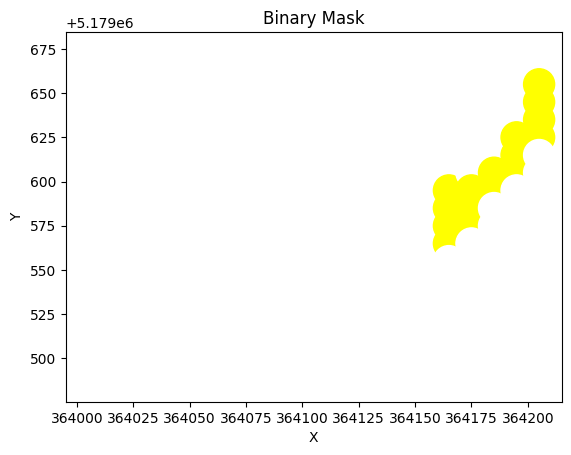

In [192]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['white', 'yellow']) #yellow for 1 and white for 0

# Plot the binary mask
plt.scatter(x, y, c=te_pred, cmap=custom_cmap, s=500)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Binary Mask')
plt.show()

### Plot the predictions - leafmap